In [1]:
# Import simulation packages
import xtrack as xt
import xpart as xp
import xobjects as xo
from cpymad.madx import Madx

# Import scientific packages
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import pandas as pd
import scipy as sp
from scipy import constants
import pybt

# Import custom signal generator
from signal_gen import generate_afg_chirp

# Import timing packages
from tqdm import tqdm
import time

# Import standard packages
import os
import json
import sys
import pickle as pkl
from collections import Counter

# Xsuite Context #############
CPU = xo.ContextCpu()        #
GPU = xo.ContextCupy()       # 
ctx = CPU                    #
##############################

TIME = 0.5
N_PART = int(50000)

# Conversion factors
RAD_TO_MRAD = 1000
M_TO_MM = 1000
MS_TO_S = 1e-3

# Beam parameters
REL_GAMMA = 25.598474067
REL_BETA = np.sqrt(1-REL_GAMMA**(-2))

exn = 2e-6
eyn = 2e-6
ex = exn/(REL_BETA*REL_GAMMA)
ey = eyn/(REL_BETA*REL_GAMMA)
# ex = 0.25e-6
# ey = 0.25e-6
# exn = ex*(REL_BETA*REL_GAMMA)
# eyn = ey*(REL_BETA*REL_GAMMA)

p = 5.392 # beam momentum (GeV/c)
momentum = p # beam momentum (GeV/c)
Brho = p*3.3356

DPP_FACTOR = 1.54e-3
# Run parameters
PARENT_DIR = "."
os.makedirs(PARENT_DIR, exist_ok=True)

LATTICE = "ps_24May.seq"

print(f"Parent Directory: {PARENT_DIR}")
mad = Madx(stdout=False)

# Import PS lattice
mad.call(LATTICE)
mad.command.beam(
    particle="PROTON",
    pc = p,
    ex = ex,
    ey = ey,
    charge = 1
)
mad.input(f"BRHO      := BEAM->PC * 3.3356;")
mad.use(sequence="PS")

# turn off 23 for ions
mad.input("kPEBSW23 := 0;")
mad.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
mad.input('savebeta, label=bumped23, place = PR.BPM23;')

def tune_match(Qx,Qxp,Qy,Qyp,p,ex,ey):
    
    mad.input('''
    ptc_twiss_macro(order, dp, slice_flag): macro = {
    ptc_create_universe;
    ptc_create_layout, time=false, model=2, exact=true, method=6, nst=3;
    IF (slice_flag == 1){
        select, flag=ptc_twiss, clear;
        select, flag=ptc_twiss, column=name,keyword,s,l,x,px,beta11,beta22,disp1,k1l;
        ptc_twiss, closed_orbit, icase=56, no=order, deltap=dp, table=ptc_twiss, summary_table=ptc_twiss_summary, slice_magnets=true;
    }
    ELSE{
        select, flag=ptc_twiss, clear;
        select, flag=ptc_twiss, column=name,keyword,s,x,px,beta11,alfa11,beta22,alfa22,disp1,disp2,mu1,mu2,energy,l,angle,K1L,K2L,K3L,HKICK,SLOT_ID;    
        ptc_twiss, closed_orbit, icase=56, no=order, deltap=dp, table=ptc_twiss, summary_table=ptc_twiss_summary, normal;
    }
    ptc_end;
    };

    ''')
    
    #/**********************************************************************************
    # *                        Matching using the PFW
    #***********************************************************************************/
    mad.input("Qx   := "+str(Qx)+"; !Horizontal Tune")
    mad.input("Qxp  := "+str(Qxp)+"; !Horizontal Chromaticity")

    mad.input("Qy   := "+str(Qy)+"; !Vertical Tune")
    mad.input("Qyp  := "+str(Qyp)+"; !Vertical Chromaticity")

    mad.input('''
    use, sequence=PS;
    match, use_macro;
            vary, name = k1prpfwf;
            vary, name = k1prpfwd;
            vary, name = k2prpfwf;
            vary, name = k2prpfwd;
            use_macro, name = ptc_twiss_macro(2,0,0);
            constraint, expr = table(ptc_twiss_summary,Q1)  = Qx;
            constraint, expr = table(ptc_twiss_summary,Q2)  = Qy;
            constraint, expr = table(ptc_twiss_summary,DQ1) = Qxp;
            constraint, expr = table(ptc_twiss_summary,DQ2) = Qyp;
    jacobian,calls=50000,bisec=3;
    ENDMATCH;
    ''')
    
    mad.use(sequence="PS")
    twiss_tune_matching = mad.twiss().dframe() # Needed to refresh the tune values
    mad.input('qx = table(SUMM, Q1);')
    mad.input('qy = table(SUMM, Q2);')
    mad.input('qxp = table(SUMM, DQ1);')
    mad.input('qyp = table(SUMM, DQ2);')
    
    tune_info_dict = {"Qx": mad.globals["qx"], "Qy": mad.globals["qy"], "Qxp": mad.globals["qxp"], "Qyp": mad.globals["qyp"]}
    pfw_dict = {"k1prpfwf": mad.globals["k1prpfwf"], "k1prpfwd": mad.globals["k1prpfwd"], "k2prpfwf": mad.globals["k2prpfwf"], "k2prpfwd": mad.globals["k2prpfwd"]}

    print (f"H-tune: {round(tune_info_dict['Qx'],3)}, H-Chroma: {round(tune_info_dict['Qxp'],3)}\nV-Tune: {round(tune_info_dict['Qy'],3)}, V-Chroma: {round(tune_info_dict['Qyp'],3)}")
    print (f"")
    print (f"PFW settings: \n  k1prpfwf: {round(pfw_dict['k1prpfwf'],6)}\n  k1prpfwd: {round(pfw_dict['k1prpfwd'],6)}\n  k2prpfwf: {round(pfw_dict['k2prpfwf'],6)}\n  k2prpfwd: {round(pfw_dict['k2prpfwd'],6)}")
    
    return pfw_dict, tune_info_dict

QX_TARGET = 0.32
QPX_TARGET = -0.5

QY_TARGET = 0.256
QPY_TARGET = -0.242

pfw_dict_on_resonance, tune_info_on_resonance = tune_match(Qx=QX_TARGET,Qxp=QPX_TARGET,Qy=QY_TARGET,Qyp=QPY_TARGET, p=p, ex=ex, ey=ey)

mad.input("k1prpfwf = "+str(pfw_dict_on_resonance["k1prpfwf"])+";")
mad.input("k1prpfwd = "+str(pfw_dict_on_resonance["k1prpfwd"])+";")
mad.input("k2prpfwf = "+str(pfw_dict_on_resonance["k2prpfwf"])+";")
mad.input("k2prpfwd = "+str(pfw_dict_on_resonance["k2prpfwd"])+";")

# Makethin
QUAD_SLICE = 4
mad.use(sequence='ps')
mad.select(flag='makethin', class_='rbend', slice_=QUAD_SLICE)
mad.select(flag='makethin', class_='quadrupole', slice_=QUAD_SLICE)
mad.select(flag='makethin', class_='sbend', slice_=QUAD_SLICE)
mad.select(flag='makethin', class_='hkicker', slice_=QUAD_SLICE, thick=False)
mad.select(flag='makethin', class_='sextupole', slice_=2)
mad.makethin(sequence='ps')
twiss_after_makethin = mad.twiss().dframe()

print("> Import Complete, MAD-X is ready to go!")


<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Parent Directory: .
H-tune: 6.32, H-Chroma: -0.508
V-Tune: 6.256, V-Chroma: -0.246

PFW settings: 
  k1prpfwf: 2.5e-05
  k1prpfwd: -0.000119
  k2prpfwf: 0.012226
  k2prpfwd: -0.020111
> Import Complete, MAD-X is ready to go!


In [2]:
interval = 5
gain = 0.8
parts_file = "pregenerated_particles.hdf"

# Convert to Xtrack
mad.use(sequence="PS")
line = xt.Line.from_madx_sequence(
    mad.sequence()
    )

line.particle_ref = xp.Particles(
    mass0=xp.PROTON_MASS_EV,
    q0=1,
    p0c=p*sp.constants.c
)

SEPTA_X_MM = -60
septum = xt.LimitRect(
        min_x = SEPTA_X_MM*0.001, # in meters
    )
line.insert_element(
    element = septum,
    name = "SEPTUM",
    index = 'pe.smh57'
)

line.build_tracker(_context=ctx)
twiss_parameters = line.twiss(method='4d')
line.unfreeze()

def kick_angle(gain):
    c = constants.c # m/s, speed of light
    E0 = 0.93827e9 # eV, proton rest energy
    mu0 = 4*np.pi*(10**-7) # H/m, vacuum permeability

    T = 2e9 # eV, proton KE
    P = 5e3 # W, TFB peak power / electrode
    Z = 100 # Ohm, TFB impedance / electrode

    L = 935e-3 # m, TFB length
    r = 70e-3 # m, TFB separation

    E = T + E0 # Total Energy
    gamma = E / E0 # Normalized energy (lorentz)
    beta = np.sqrt(1-gamma**-2) # normalised velocity (lorentz)
    cp = np.sqrt(E**2 - E0**2) # eV, particle momentum

    # Electric Field
    Vp = np.sqrt(P * Z * 2) # peak voltage
    V = Vp * gain
    Efield = V / r # adjusted for gain

    # Magnetic Field
    I = np.sqrt((V**2/Z)/Z*2) # current
    Hfield = (2*I) / (2*np.pi*r) # adjusted for gain
    Bfield = Hfield * mu0

    # Angle
    theta_M = c/1e9*Bfield*L / (cp/10**9)
    theta_E = Efield/1e9*L / (cp/10**9 * beta)
    theta = theta_E + theta_M
    return theta

rfko_kick = kick_angle(float(gain))

trev = twiss_parameters['T_rev0']
frev = 1/trev

sampling_freq = 1e9

chirp_time, chirp_signal, chirp_turns = generate_afg_chirp(
    chirp_rep_time = float(interval)*MS_TO_S,
    turn_freq = frev,
    chirp_middle = frev / 0.325,
    chirp_dev = frev / 0.025,
    sampling_freq = sampling_freq
)

rfko_exciter = xt.Exciter(
    _context = ctx,
    samples = chirp_signal,
    sampling_frequency = sampling_freq,
    frev = frev,
    duration = TIME,
    start_turn = 0,
    knl = [rfko_kick]
)
line.insert_element(
    element = rfko_exciter,
    name = f'EXCITER',
    index = 'pr.kfb97'
)


Converting sequence "ps": 99%     
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [3]:
print(gamma_tr := 1/np.sqrt(twiss_parameters['momentum_compaction_factor']))

6.2220284537605615


In [4]:
RF_HARMONIC = 8
RF_FREQUENCY = frev * RF_HARMONIC

RF_VOLTAGE = 130e3 # V
PHASE = 0 # rising-edge

rf_cavity = xt.Cavity(
    _context = ctx,
    voltage = RF_VOLTAGE,
    frequency = RF_FREQUENCY,
    lag = PHASE
)

line.insert_element(
    element = rf_cavity,
    name = "rf_cavity",
    at_s = 0
)

In [5]:
line.build_tracker(_context=ctx)
line.particle_ref = xp.Particles(
    mass0=xp.PROTON_MASS_EV,
    q0=1,
    p0c=p*sp.constants.c
)
particles = xp.generate_matched_gaussian_bunch(
    line = line,
    num_particles = N_PART,
    nemitt_x = exn,
    nemitt_y = eyn,
    sigma_z = 50,
    total_intensity_particles = 30e10
)


Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Given RMS bunch length does not fit into bucket. Using (maximum) full bucket RMS bunch length 12.254589270982285m instead.


*** Maximum RMS bunch length 12.378373000992207m.


/opt/homebrew/Caskroom/miniconda/base/envs/cern/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1151: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
RFBucketMatcher: failed to converge with Brent method, continuing with Newton-Raphson method.


... distance to target bunch length: -1.2132e+01
... distance to target bunch length: -2.1772e-01
... distance to target bunch length: -1.4047e+00
... distance to target bunch length: -1.4043e+00
... distance to target bunch length: -5.9178e-01
... distance to target bunch length: -3.4998e-01
... distance to target bunch length: -1.7078e-01
... distance to target bunch length: -8.0517e-02
... distance to target bunch length: -3.1004e-02
... distance to target bunch length: -8.6564e-03
... distance to target bunch length: -1.2849e-03
... distance to target bunch length: -6.3188e-05
... distance to target bunch length: -4.8757e-07
... distance to target bunch length: -1.8660e-10
--> Bunch length: 12.25458927098228
--> Emittance: 1.885974564584634


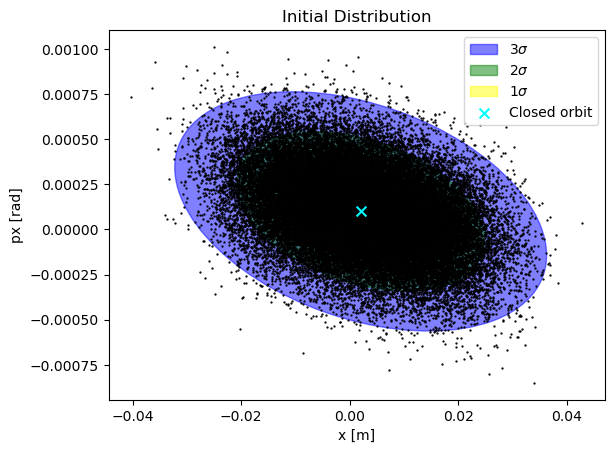

In [6]:
fig, ax = plt.subplots()
cov = np.cov([particles.x, particles.px])
cov_px = np.cov(particles.px)

w3, h3, r3 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=3)
w2, h2, r2 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=2)
w1, h1, r1 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=1)

tw = line.twiss()
co = line.find_closed_orbit()
parms = pybt.tools.particles.get_parms(particles.x, particles.px)

from matplotlib.patches import Ellipse, Rectangle
e3 = Ellipse(xy=(co.x[0], co.px[0]), width=w3, height=h3, angle=r3, color='blue', alpha=.5, label='3$\sigma$')
e2 = Ellipse(xy=(co.x[0], co.px[0]), width=w2, height=h2, angle=r2, color='green', alpha=.5, label='2$\sigma$')
e1 = Ellipse(xy=(co.x[0], co.px[0]), width=w1, height=h1, angle=r1, color='yellow', alpha=.5, label='1$\sigma$')
ax.add_artist(e3)
ax.add_artist(e2)
ax.add_artist(e1)

ax.scatter(particles.x, particles.px, s=0.4, color='k')

ax.scatter(co.x, co.px, color='cyan', marker='x', s=50, label='Closed orbit', zorder=4)
ax.set_title("Initial Distribution")
ax.set_xlabel('x [m]')
ax.set_ylabel('px [rad]')
ax.legend()


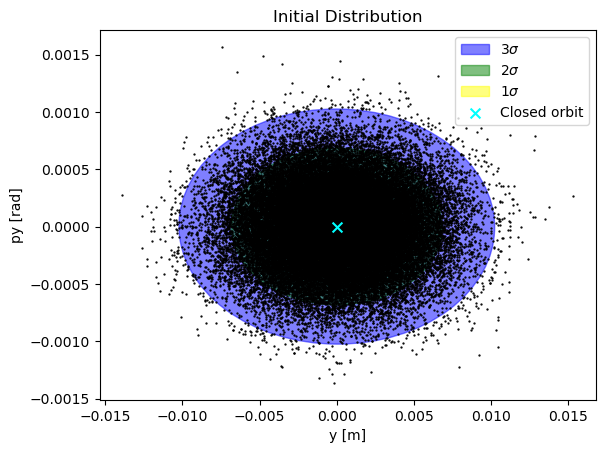

In [7]:
fig, ax = plt.subplots()
cov = np.cov([particles.y, particles.py])
cov_px = np.cov(particles.py)

w3, h3, r3 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=3)
w2, h2, r2 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=2)
w1, h1, r1 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=1)

tw = line.twiss()
parms = pybt.tools.particles.get_parms(particles.y, particles.py)

from matplotlib.patches import Ellipse, Rectangle
e3 = Ellipse(xy=(co.y[0], co.py[0]), width=w3, height=h3, angle=r3, color='blue', alpha=.5, label='3$\sigma$')
e2 = Ellipse(xy=(co.y[0], co.py[0]), width=w2, height=h2, angle=r2, color='green', alpha=.5, label='2$\sigma$')
e1 = Ellipse(xy=(co.y[0], co.py[0]), width=w1, height=h1, angle=r1, color='yellow', alpha=.5, label='1$\sigma$')
ax.add_artist(e3)
ax.add_artist(e2)
ax.add_artist(e1)

ax.scatter(particles.y, particles.py, s=0.4, color='k')
co = line.find_closed_orbit()
ax.scatter(co.y, co.py, color='cyan', marker='x', s=50, label='Closed orbit', zorder=4)
ax.set_title("Initial Distribution")
ax.set_xlabel('y [m]')
ax.set_ylabel('py [rad]')
ax.legend()


In [8]:
N_TURN = int(TIME*frev)

In [9]:

for _ in tqdm(range(N_TURN)):
    line.track(particles, num_turns = 1)

particles_lost_at_each_turn = np.bincount(ctx.nparray_from_context_array(particles.at_turn))

constants_dict = {
    "gain": gain,
    "interval": interval,
    "n_turn": N_TURN,
    "frev": frev,
    "n_part": N_PART,
    "rfko_kick": rfko_kick,
#    "time_taken": time_taken
}


100%|██████████| 206328/206328 [3:25:31<00:00, 16.73it/s]  


In [10]:
t = (particles.at_turn/frev) - (particles.zeta/REL_BETA/sp.constants.c)
max_time = np.max(t)
sample_rate = 20000  # 20 kHz
total_samples = int(np.ceil(max_time * sample_rate))  # Using np.ceil to round up and ensure that all times are within the array
time_series_data = np.zeros(total_samples)
arrival_indices = np.floor(t * sample_rate).astype(int)
for idx in arrival_indices:
    time_series_data[idx] += 1
time_series_time = np.arange(total_samples) / sample_rate

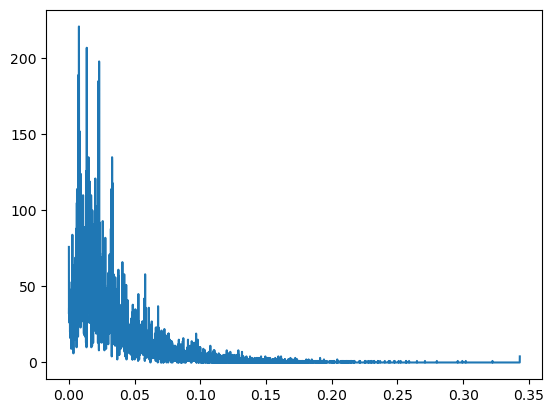

In [11]:
fig, ax = plt.subplots()
#ax.plot(t)
ax.plot(time_series_time, time_series_data)